In [1]:
import random
import time
from rangeindex import RangeIndex
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
alpha = 'qwertyuiopasdfghjklzxcvbnm'
nums = list(range(10**4))
w_length = 5

class Thing():
    def __init__(self):
        self.f0 = random.random()
        self.f1 = random.random()
        self.f2 = random.random()
        self.f3 = random.random()
        self.f4 = random.random()
        self.f5 = random.random()
        self.f6 = random.random()
        self.f7 = random.random()
        self.f8 = random.random()
        self.f9 = random.random()
        self.data = '12894398ur8fehsiungjksgkjshgkdkh'
"""
self.c0 = random.choice(alpha)
self.c1 = random.choice(alpha)
self.c2 = random.choice(alpha)
self.c3 = random.choice(alpha)
self.c4 = random.choice(alpha)
self.c5 = random.choice(alpha)
self.c6 = random.choice(alpha)
self.c7 = random.choice(alpha)
self.c8 = random.choice(alpha)
self.c9 = random.choice(alpha)
self.w0 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w1 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w2 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w3 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w4 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w5 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w6 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w7 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w8 = ''.join(random.choice(alpha) for _ in range(w_length))
self.w9 = ''.join(random.choice(alpha) for _ in range(w_length))
self.i0 = random.choice(nums)
self.i1 = random.choice(nums)
self.i2 = random.choice(nums)
self.i3 = random.choice(nums)
self.i4 = random.choice(nums)
self.i5 = random.choice(nums)
self.i6 = random.choice(nums)
self.i7 = random.choice(nums)
self.i8 = random.choice(nums)
self.i9 = random.choice(nums)
"""
EXP = 7
things = [Thing() for _ in range(10**EXP)]

Let's benchmark on some floats!

In [3]:
engines = ['pandas', 'sqlite']

In [4]:
def generate_float_range(n_results=1, n_idx=1, dataset_size=10**EXP) -> tuple[float, float]:
    """
    Generate a range of float values that, when queried, will return approx n_results items.
    Example: if n_idx is 1, and we want 1/10 of the items in the dataset, we could return (0.5, 0.6)
    as that will be 1/10 of the items.
    But if n_idx is 2, we want a range of 0.1**(1/2) items, to account for the fact that we have 
    two independent value ranges.
    """
    width = (n_results / dataset_size)**(1/n_idx)
    lim_1 = random.random()*(1-width)
    lim_2 = lim_1 + width
    return lim_1, lim_2


In [5]:
def bench_floats(n_idx=1, n_runs=5):
    results = {}
    n_runs = 10
    fields = {f'f{i}': float for i in range(n_idx)}
    ris = []
    for engine in engines:
        if engine == 'sqlite':
            ri = RangeIndex(things, fields,  engine, table_index=[('f0', 'f1')])
        else:
            ri = RangeIndex(things, fields,  engine)
        ris.append(ri)
    ris.append('linear')
    for ri in ris:
        for n_items in [10**e for e in range(0, EXP+1)]:
            # Run 2 bechmarks, take the second. Queries are randomized so this isn't a cache cheat.
            # Rather, this gives a "warm-up" round so that the data more accurately reflects
            # the performance you'd get at steady-state.
            # Without this, you get really weird distorted data.
            for _ in range(2):  
                t_tot = 0
                n_tot = 0
                for run in range(n_runs):
                    lo, hi = generate_float_range(n_items, n_idx)
                    if ri == 'linear':
                        q = ' and '.join([
                            f't.f{i} > {lo} and t.f{i} <= {hi}'
                            for i in range(n_idx)
                        ])
                        t0 = time.time()
                        items_got = eval(f'[t for t in things if {q}]')
                        t1 = time.time()
                    else:
                        q = ' and '.join([
                            f'f{i} > {lo} and f{i} <= {hi}'
                            for i in range(n_idx)
                        ])
                        t0 = time.time()
                        items_got = ri.find(q)
                        t1 = time.time()
                    t_tot += (t1-t0) / n_runs
                    n_tot += len(items_got) / n_runs
                if ri == 'linear':
                    cond = 'linear'
                else:
                    cond = ri.engine
                results[(cond, n_items)] = {'got': n_tot, 'time': t_tot}

    return results

In [6]:
def time_str(t: float) -> str:
    if t < 10 ** -4:
        return "{}μs".format(round(t * 10 ** 6, 1))
    elif t < 10 ** -1:
        return "{}ms".format(round(t * 10 ** 3, 1))
    else:
        return "{}s".format(round(t, 2))

def num_str(n: int) -> str:
    if n >= 10 ** 9:
        return "{}B".format(int(round(n / 10 ** 9)))
    elif n >= 10 ** 6:
        return "{}M".format(int(round(n / 10 ** 6)))
    elif n >= 10 ** 3:
        return "{}K".format(int(round(n / 10 ** 3)))
    else:
        return str(n)

In [7]:
# raw numbers, much better for tweaking

for n_idx in [2]:
    results = bench_floats(n_idx=n_idx)
    plt.figure(figsize=(20,10))
    if n_idx == 1:
        title = '1 field indexed'
    else:
        title = f'{n_idx} fields indexed'
    print(title)

    for i, engine in enumerate(engines + ['linear']):
        for n_items in [10**e for e in range(0, EXP+1)]:
            baseline = results[('linear', n_items)]['time']
            result = results[(engine, n_items)]['time']
            speedup = round(baseline/result, 3)
            print(f'{engine}, {num_str(n_items)}: {time_str(result)}\t\t({speedup})')


2 fields indexed
pandas, 1: 43.1ms		(21.97)
pandas, 10: 44.9ms		(20.047)
pandas, 100: 43.8ms		(22.963)
pandas, 1K: 43.9ms		(23.729)
pandas, 10K: 47.6ms		(24.046)
pandas, 100K: 88.3ms		(13.718)
pandas, 1M: 0.2s		(10.242)
pandas, 10M: 0.5s		(6.391)
sqlite, 1: 0.2ms		(4124.44)
sqlite, 10: 0.7ms		(1382.198)
sqlite, 100: 1.9ms		(519.747)
sqlite, 1K: 6.7ms		(155.984)
sqlite, 10K: 27.2ms		(42.043)
sqlite, 100K: 0.2s		(7.868)
sqlite, 1M: 1.4s		(1.216)
sqlite, 10M: 10.6s		(0.275)
linear, 1: 0.9s		(1.0)
linear, 10: 0.9s		(1.0)
linear, 100: 1.0s		(1.0)
linear, 1K: 1.0s		(1.0)
linear, 10K: 1.1s		(1.0)
linear, 100K: 1.2s		(1.0)
linear, 1M: 1.7s		(1.0)
linear, 10M: 2.9s		(1.0)


<Figure size 1440x720 with 0 Axes>

2 fields indexed


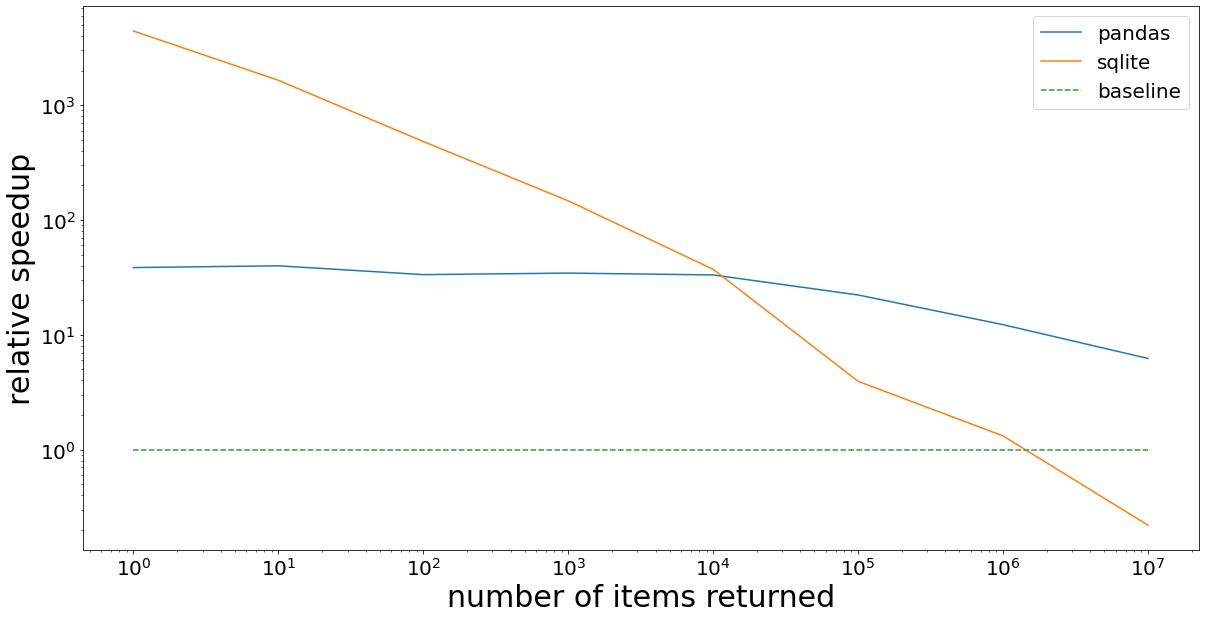

In [8]:
matplotlib.rc('font', size=20)

# for n_idx in [1, 2, 5, 10]:
for n_idx in [2]:
    results = bench_floats(n_idx=n_idx)
    plt.figure(figsize=(20,10))
    if n_idx == 1:
        title = '1 field indexed'
    else:
        title = f'{n_idx} fields indexed'
    print(title)
    # plt.title(f'{title}', fontsize=30)

    for i, engine in enumerate(engines):
        x = []
        y = []
        for n_items in [10**e for e in range(0, EXP+1)]:
            baseline = results[('linear', n_items)]['time']
            result = results[(engine, n_items)]['time']
            speedup = round(baseline/result, 3)
            #print(f'{engine}, {n_items}: {speedup}x')
            x.append(n_items)
            y.append(speedup)
        plt.loglog(x, y, label=engine)
        plt.xlabel('number of items returned')
        plt.ylabel('relative speedup')
    plt.loglog([1, 10**EXP], [1, 1], '--', label='baseline')
    plt.xlabel('number of items returned', fontsize=30)
    plt.ylabel('relative speedup', fontsize=30)
    plt.legend()
    plt.show()

In [9]:
# quick check, how much of that is dict lookup?
obj_ids = [id(t) for t in things]
obj_dict = {id(t): t for t in things}

t0 = time.time()
zz = [obj_dict[obj_id] for obj_id in obj_ids[:len(obj_ids)//100]]
t1 = time.time()
print('dict lookup of 100K items:', t1-t0)

t0 = time.time()
zz = [obj_dict[obj_id] for obj_id in obj_ids[:len(obj_ids)//10]]
t1 = time.time()
print('dict lookup of 1M items:', t1-t0)

t0 = time.time()
zz = [obj_dict[obj_id] for obj_id in obj_ids]
t1 = time.time()
print('dict lookup of 10M items:', t1-t0)

dict lookup of 100K items: 0.012914419174194336
dict lookup of 1M items: 0.15543532371520996
dict lookup of 10M items: 1.9858479499816895


In [10]:
(0.408)/(0.408-0.1179*5/6)

1.3171912832929782